In [102]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [124]:
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 12
threshold=2_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
sbo = -0.05
sso = -1.25
sbc = 1.5
ssc = 0.09

# Functions

In [114]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

def create_signal_past(data, sbo, sso, sbc, ssc):
    def apply_rules(group):
        position = None
        signals = []

        for s_score in group['s_score']:
            if position is None:
                if s_score < -sbo:
                    position = 'buy'
                    signals.append('buy to open')
                elif s_score > sso:
                    position = 'sell'
                    signals.append('sell to open')
                else:
                    signals.append(None)
            elif position == 'buy':
                if s_score > -ssc:
                    position = None
                    signals.append('close long')
                else:
                    signals.append('hold')
            elif position == 'sell':
                if s_score < sbc:
                    position = None
                    signals.append('close short')
                else:
                    signals.append('hold')
            else:
                signals.append(None)

        return pd.Series(signals, index=group.index)

    # Sort data by permno and date for consistency
    data = data.sort_values(by=['permno', 'date'])
    # Group by permno and apply the rules for each group
    data['signal'] = data.groupby('permno').apply(lambda x: apply_rules(x)).reset_index(level=0, drop=True)
    return data

def comp_port_ret(df, threshold):
    # Map signal to its corresponding position
    position_map = {
        'buy to open': 'long',
        'sell to open': 'short',
        'close long': 'close',
        'close short': 'close'
    }
    
    # Create a 'position' column based on 'signal' column
    df['position'] = df['signal'].map(position_map)
    
    # Nullify the 'position' where the 'market_cap' is below the threshold before forward filling
    df.loc[df['market_cap'] < threshold, 'position'] = None

    # Forward fill the 'position' column to carry forward the positions until a 'close' signal appears
    df['position'] = df['position'].ffill().where(df['position'] != 'close')

    # Create a shifted position column to identify the initial signals
    df['shifted_position'] = df['position'].shift(1)
    
    # Extract all beta columns and compute the cumulative hedge return
    beta_columns = [col for col in df.columns if '_sector_' in col]
    hedge_return = sum(df[beta] * df[beta.split('_sector_')[0].replace('_sector_', '')] for beta in beta_columns)

    # Create conditions
    long_condition = (df['position'] == 'long') & (df['market_cap'] >= threshold)
    short_condition = (df['position'] == 'short') & (df['market_cap'] >= threshold)
    close_condition = df['position'] == 'close'
    initial_long_condition = (df['shifted_position'] != 'long') & long_condition
    initial_short_condition = (df['shifted_position'] != 'short') & short_condition

    # Compute portfolio returns
    df['port_ret'] = np.where(initial_long_condition | initial_short_condition, 0,
                              np.where(long_condition, df['RET_01'] - hedge_return,
                                       np.where(short_condition, -df['RET_01'] + hedge_return,
                                                np.where(close_condition, 0, 0))))

    return df[['port_ret']]

# Calculate S Score

In [115]:
factor_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

# Read in live market data
sector_df = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=past_date)
T = [1]
sector_df = sector_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_df = sector_df.rename(columns={'Adj Close': 'Close'})

sector_df = create_return(sector_df, T)
sector_df = sector_df.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df = sector_df.unstack('ticker').swaplevel(axis=1)
sector_df.columns = ['_'.join(col).strip() for col in sector_df.columns.values]

sector_data = sector_df
sector_data = sector_data.loc[start:past_date]
sector_data = sector_data.fillna(0)

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/ticker]


In [116]:
T = [1]
factor_col = sector_data.columns
factor_data = create_return(factor_data, T)
factor_data = factor_data.fillna(0)

In [117]:
ret = f'RET_01'
beta_data = rolling_ols_parallel(data=factor_data, ret=ret, factor_data=sector_data, factor_cols=factor_col.tolist(), window=window, name=f'sector_01')
beta_data = beta_data[beta_data.columns[1:11]]
beta_data['Xk'] = beta_data[f'epsil_sector_01_{window:02}'].rolling(12).sum()
beta_data['Xk_lag'] = beta_data['Xk'].groupby('permno').shift(-1)
beta_data['Xk_diff'] = beta_data['Xk'].groupby('permno').diff()
beta_data = beta_data.fillna(0)
beta_data.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [118]:
def per_stock(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].fillna(0)
    rolling_ols = RollingOLS(endog=model_data[ret], exog=sm.add_constant(model_data[factor_col]), window=window)
    factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    result = factor_model.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

def exec_ou(data, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(per_stock)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [119]:
ou_data = exec_ou(beta_data).droplevel(0)
ou_data.columns = ['a', 'b']
ou_data = ou_data.merge(beta_data[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')
ou_data['kappa'] = -np.log(ou_data['b']) * 252
ou_data['m'] = ou_data['a'] / (1 - ou_data['b'])
ou_data['sigma'] = np.sqrt(ou_data['Xk_diff'].var() * 2 * ou_data['kappa'] / (1 - ou_data['b']**2))
ou_data['sigma_eq'] = np.sqrt(ou_data['Xk_diff'].var() / (1 - ou_data['b']**2))
ou_data['s_score'] = -ou_data['m'] / ou_data['sigma_eq']
ou_data.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

# Backtest

In [120]:
sector_multi = create_multi_index(sector_df, stock)
combined = ou_data[['s_score']].merge(beta_data, left_index=True, right_index=True, how='left')
combined = combined.merge(sector_multi, left_index=True, right_index=True, how='left')
combined = combined.merge(factor_data[['RET_01']], left_index=True, right_index=True, how='left')
combined = combined.fillna(0)

In [121]:
combined

s_score  XLB_RET_01_sector_01_12  XLE_RET_01_sector_01_12  \
permno date                                                                     
10078  2005-01-03  0.000000                 0.000000                 0.000000   
       2005-01-04  0.000000                 0.000000                 0.000000   
       2005-01-05  0.000000                 0.000000                 0.000000   
       2005-01-06  0.000000                 0.000000                 0.000000   
       2005-01-07  0.000000                 0.000000                 0.000000   
...                     ...                      ...                      ...   
93436  2023-10-27 -0.374578                 2.128743                -2.432185   
       2023-10-30 -0.491684                -3.742025                 1.493250   
       2023-10-31 -0.498540                -2.727351                 0.955638   
       2023-11-01 -0.465524                -4.670737                 2.110847   
       2023-11-02 -0.284038                -4.393843                 1.280747   

                   XLF_RET_01_sector_01_12  XLI_RET_01_sector_01_12  \
permno date                                                           
10078  2005-01-03                 0.000000                 0.000000   
       2005-01-04                 0.000000                 0.000000   
       2005-01-05                 0.000000                 0.000000   
       2005-01-06                 0.000000                 0.000000   
       2005-01-07                 0.000000                 0.000000   
...                                    ...                      ...   
93436  2023-10-27                 6.854283                -7.710959   
       2023-10-30                -2.246670                 3.661668   
       2023-10-31                 1.188270                -1.188443   
       2023-11-01                -1.165255                 2.942308   
       2023-11-02                -0.215990                 1.659877   

                   XLK_RET_01_sector_01_12  XLP_RET_01_sector_01_12  \
permno date                                                           
10078  2005-01-03                 0.000000                 0.000000   
       2005-01-04                 0.000000                 0.000000   
       2005-01-05                 0.000000                 0.000000   
       2005-01-06                 0.000000                 0.000000   
       2005-01-07                 0.000000                 0.000000   
...                                    ...                      ...   
93436  2023-10-27                 0.740232                 0.597362   
       2023-10-30                -4.228888                 0.551735   
       2023-10-31                -2.881337                -2.884305   
       2023-11-01                -4.078318                -2.300150   
       2023-11-02                -3.347655                -2.505757   

                   XLU_RET_01_sector_01_12  XLV_RET_01_sector_01_12  \
permno date                                                           
10078  2005-01-03                 0.000000                 0.000000   
       2005-01-04                 0.000000                 0.000000   
       2005-01-05                 0.000000                 0.000000   
       2005-01-06                 0.000000                 0.000000   
       2005-01-07                 0.000000                 0.000000   
...                                    ...                      ...   
93436  2023-10-27                -2.031217                 1.787944   
       2023-10-30                 2.651145                -4.592667   
       2023-10-31                 2.160297                -0.570314   
       2023-11-01                 3.119704                -2.706009   
       2023-11-02                 3.015664                -1.978044   

                   XLY_RET_01_sector_01_12  ...  XLB_RET_01  XLE_RET_01  \
permno date                                 ...                           
10078  2005-01-03                 0.000000  

In [112]:
combined = combined[['s_score', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [11]:
result = create_signal_past(combined, sbo, sso, sbc, ssc)

In [12]:
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
result = result.merge(misc, left_index=True, right_index=True, how='left')

In [14]:
# Calculate Portfolio Ret
result['port_ret'] = result.groupby(level=0).apply(comp_port_ret, threshold=threshold).reset_index(level=0, drop=True)
# Get the first date of each year
first_dates_per_year = result.reset_index().groupby(result.index.get_level_values('date').year)['date'].first()
# Map these first dates to the number of stocks at the beginning of the year
stocks_count_dict = {date: len(get_stock_idx(set_timeframe(result, str(date.year), str(date.year + 1)))) for date in first_dates_per_year}
# Use the map function to quickly assign the number of stocks for each date
result['num_stock'] = result.index.get_level_values('date').map(stocks_count_dict)
result['num_stock'] = result['num_stock'].ffill()
result['weight'] = 1 / result['num_stock']
result['weight_port_ret'] = result['weight'] * result['port_ret']
ewp_ret = result.groupby('date')['weight_port_ret'].sum()

In [15]:
result[['signal', 'market_cap', 'port_ret', 'num_stock', 'weight', 'weight_port_ret']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

## Plot

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-31   2005-01-31
End Period                 2023-11-01   2023-11-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          259.93%      1,300.90%
CAGR﹪                     4.83%        10.2%

Sharpe                     0.45         2.14
Prob. Sharpe Ratio         97.37%       100.0%
Smart Sharpe               0.43         2.07
Sortino                    0.63         3.67
Smart Sortino              0.61         3.56
Sortino/√2                 0.44         2.6
Smart Sortino/√2           0.43         2.52
Omega                      1.64         1.64

Max Drawdown               -56.47%      -10.94%
Longest DD Days            1982         163
Volatility (ann.)          19.44%       6.69%
R^2                        0.12         0.12
Information Ratio          0.02         0.02
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-08-29,2008-10-27,2008-12-29,123,-10.936303,-10.418514
2,2009-05-07,2009-07-07,2009-07-10,65,-6.608121,-6.446458
3,2022-06-08,2022-06-22,2022-07-26,49,-5.833991,-5.813170
4,2016-06-09,2016-06-27,2016-06-29,21,-5.508476,-3.221794
5,2022-01-05,2022-03-07,2022-03-24,79,-4.854334,-4.816330


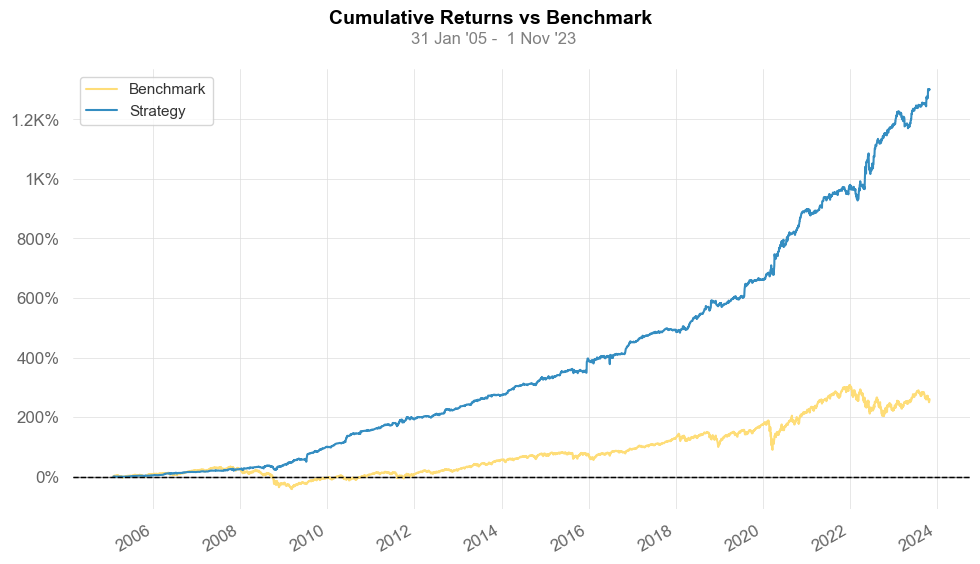

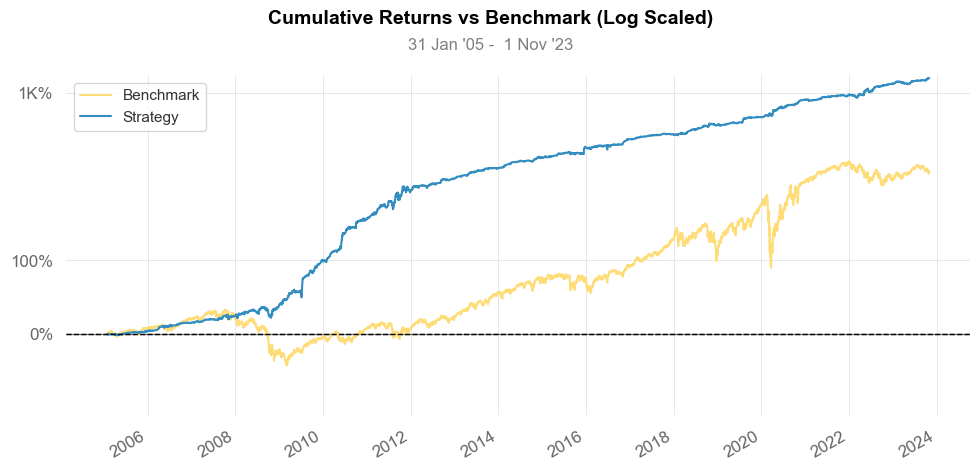

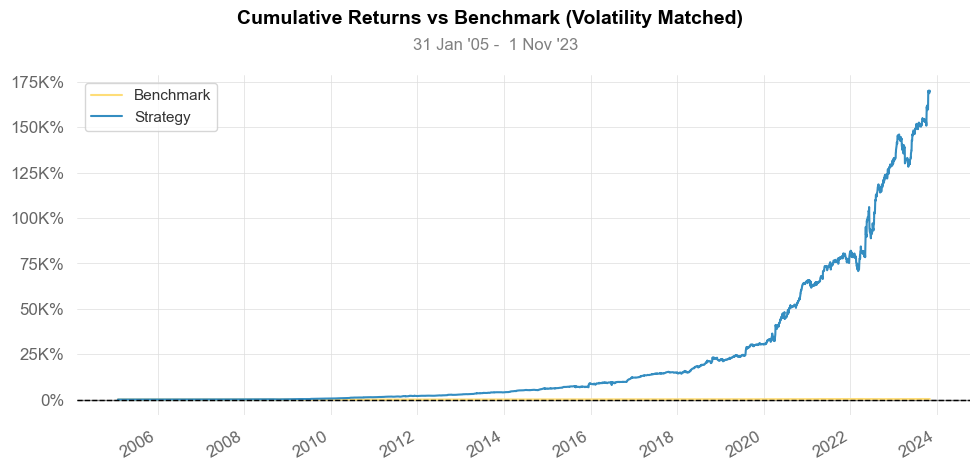

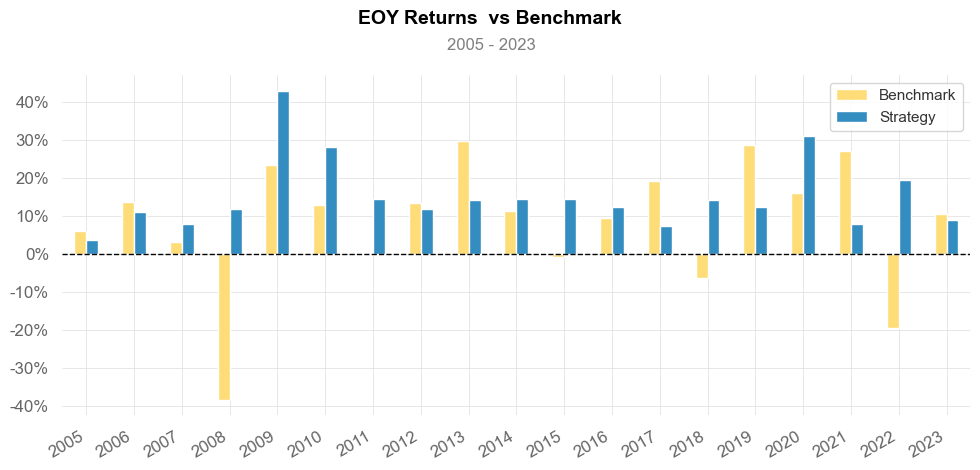

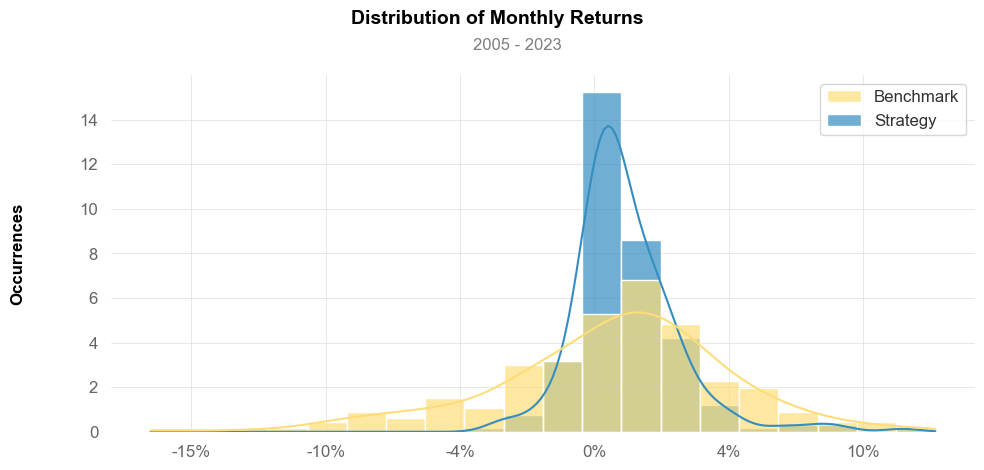

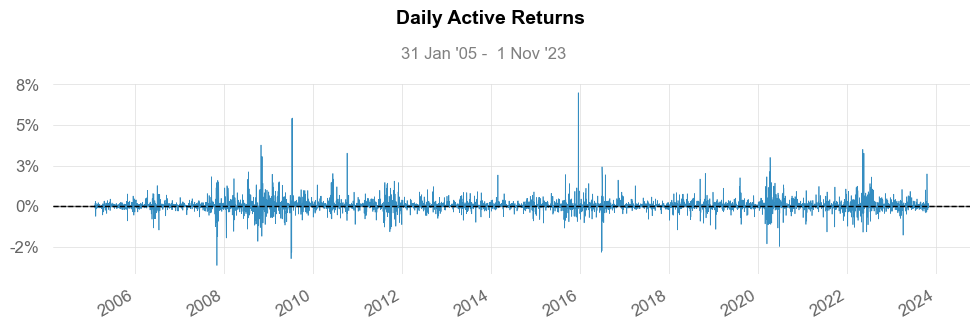

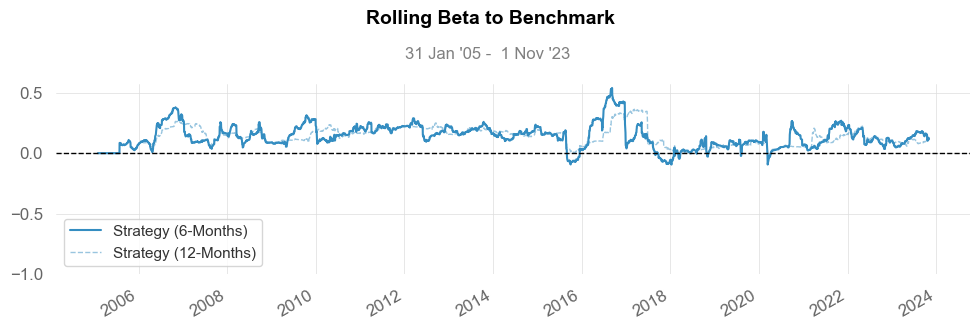

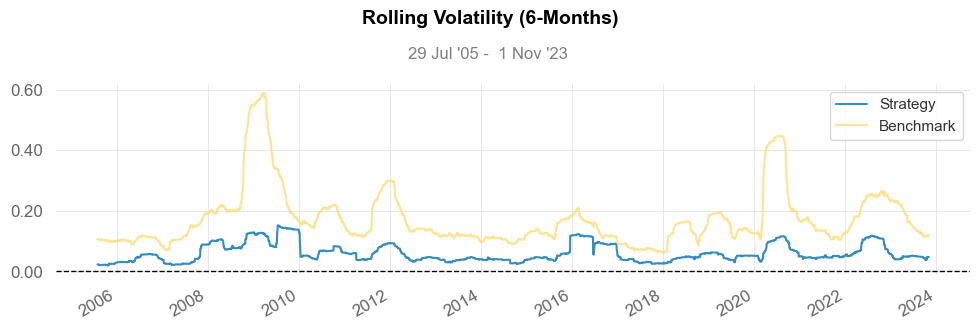

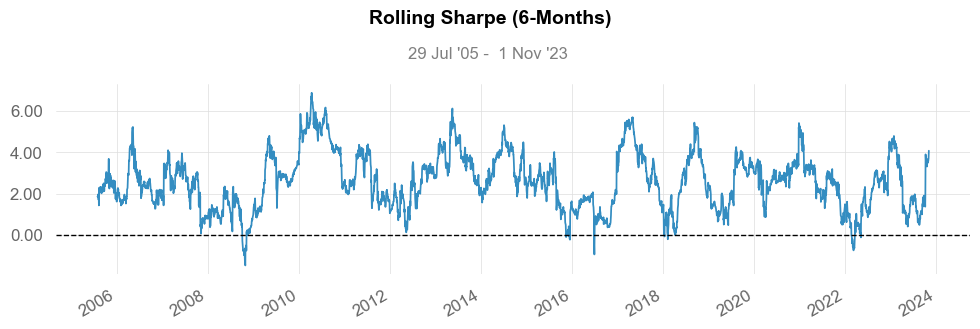

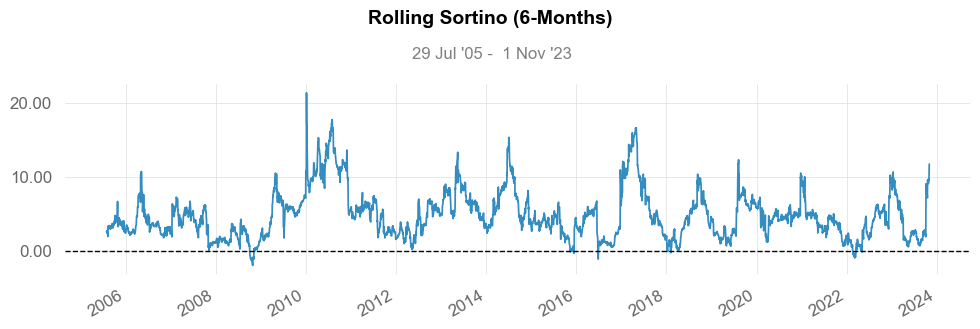

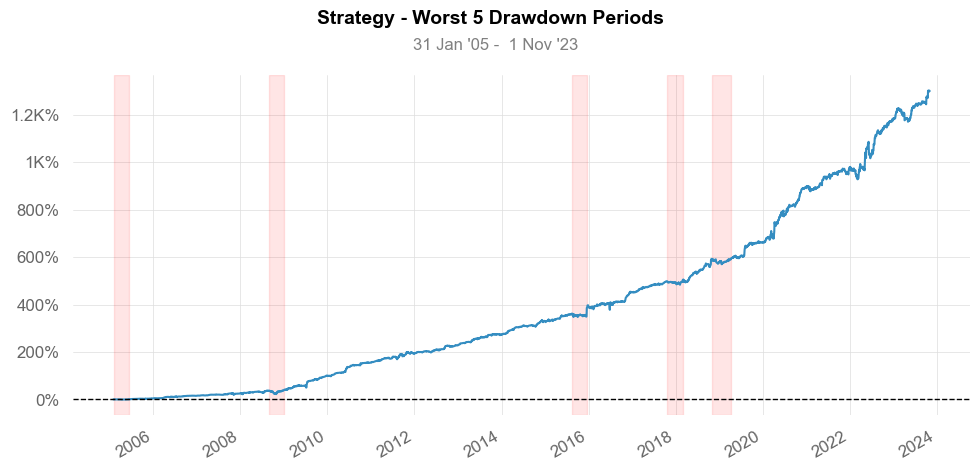

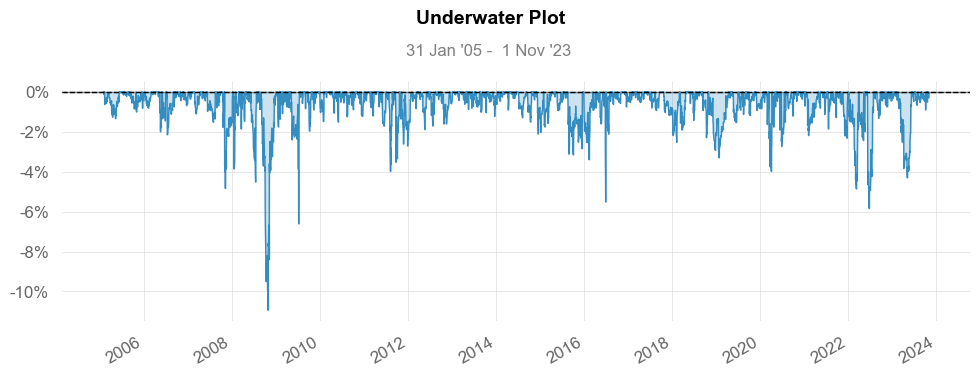

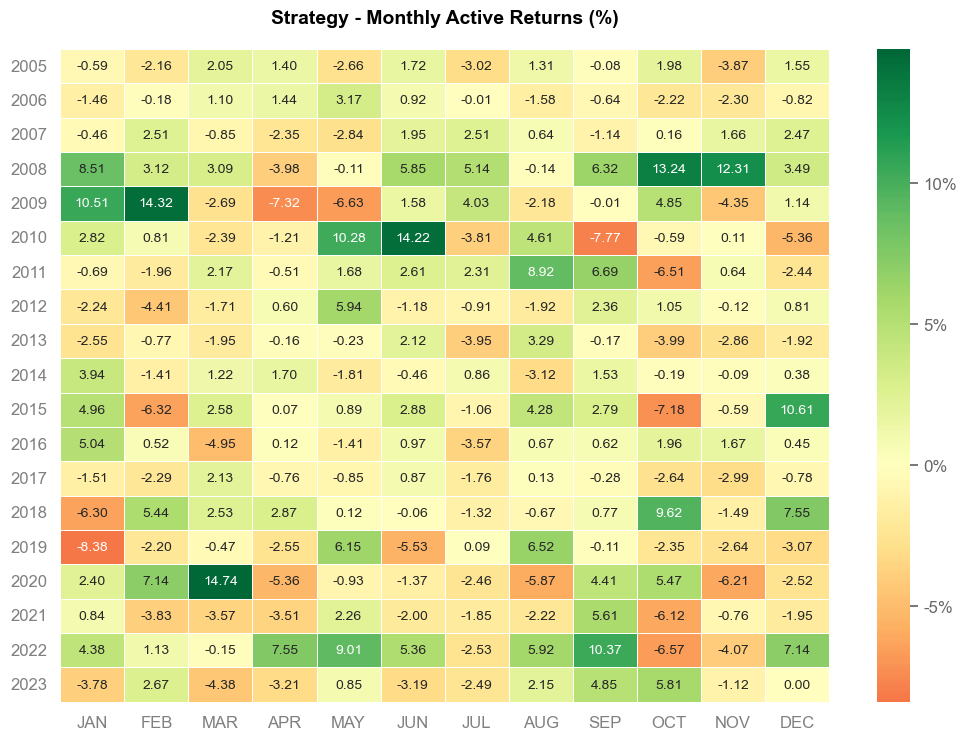

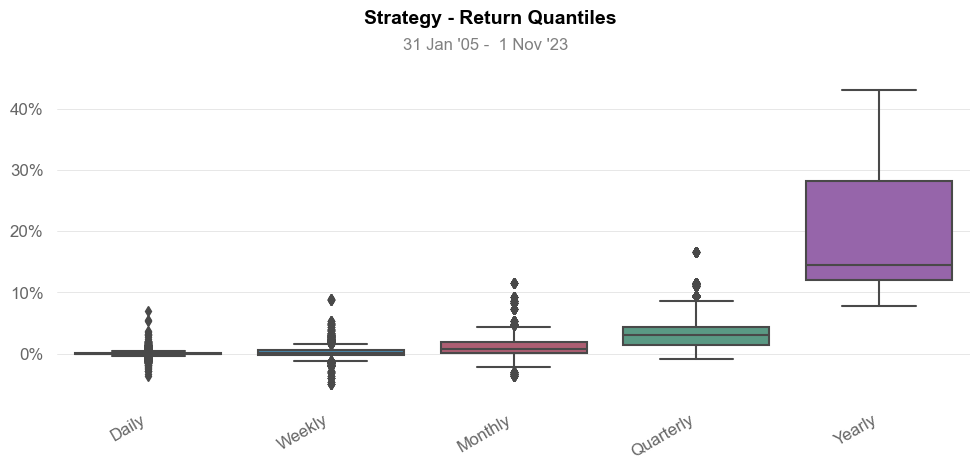

In [16]:
qs.reports.full(ewp_ret, "SPY", figsize=(10, 5))

# Live

In [17]:
live_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

# Read in live market data
sector_df_live = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
T = [1]
sector_df_live = sector_df_live[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_df_live = sector_df_live.rename(columns={'Adj Close': 'Close'})

sector_df_live = create_return(sector_df_live, T)
sector_df_live = sector_df_live.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_df_live = sector_df_live.unstack('ticker').swaplevel(axis=1)
sector_df_live.columns = ['_'.join(col).strip() for col in sector_df_live.columns.values]

sector_data_live = sector_df_live
sector_data_live = sector_data_live.loc[start:current_date]
sector_data_live = sector_data_live.fillna(0)

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04ticker/s]


In [18]:
T = [1]
factor_col_live = sector_data_live.columns
live_data = create_return(live_data, T)
live_data = live_data.fillna(0)

In [19]:
def current_data(group):
    # Make sure that the group has at least 'window' trading days data up to the current_date
    recent_dates = group.index.get_level_values('date')
    target_date = pd.to_datetime(current_date) - BDay(window)
    return recent_dates.max() >= target_date and (recent_dates >= target_date).sum() >= window

In [20]:
def per_stock_ols_last(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
    model_data = stock_data[[ret]].merge(factor_data, on='date').dropna()
    model_data = model_data[[ret] + factor_cols]
    model_data = model_data.iloc[-window:]
        
    exog = sm.add_constant(model_data[factor_cols])
    model = OLS(model_data[ret], exog)
    results = model.fit()

    # Get the parameters and other statistics
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)

    # Calculate predicted values
    predicted = results.predict(exog)
    predicted.name = 'pred'

    # Compute residuals (epsilon)
    epsilon = model_data[ret] - predicted
    epsilon.name = 'epsil'

    result = factor_model_params.assign(epsil=epsilon, pred=predicted)
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

def rolling_ols_last(data, ret, factor_data, factor_cols, window, name):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group)]
    tasks = [(group, ret, factor_data, factor_cols, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ols_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [21]:
ret = f'RET_01'
beta_data_live = rolling_ols_last(data=live_data, ret=ret, factor_data=sector_data_live, factor_cols=factor_col_live.tolist(), window=window, name=f'sector_01')
beta_data_live = beta_data_live[beta_data_live.columns[1:11]]

In [22]:
# Combine live beta with historical beta
beta_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')
beta_data_live = pd.concat([beta_data_past, beta_data_live], axis=0).sort_index(level=['permno', 'date'])

In [23]:
# Calculate Xk and shift it for permnos that are currently live
current_permnos = beta_data_live[beta_data_live.index.get_level_values('date') == pd.to_datetime(current_date)].index.get_level_values('permno').unique()
window_sums = beta_data_live[beta_data_live.index.get_level_values('permno').isin(current_permnos)].groupby('permno')[f'epsil_sector_01_{window:02}'].transform(lambda x: x.tail(window).sum())
last_indices = beta_data_live.loc[(slice(None), current_date), :].index
beta_data_live.loc[last_indices, 'Xk'] = window_sums.loc[last_indices]
beta_data_live['Xk_lag'] = beta_data_live['Xk'].groupby('permno').shift(-1)
beta_data_live['Xk_diff'] = beta_data_live['Xk'].groupby('permno').diff()
beta_data_live = beta_data_live.fillna(0)
beta_data_live.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [24]:
def per_stock_ou_last(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data.iloc[-window:]
    exog = sm.add_constant(model_data[factor_col])
    model = OLS(model_data[ret], exog)
    results = model.fit()
    
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)

    result = factor_model_params
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

def exec_ou_last(data, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group)]
    tasks = [(group, ret, factor_col, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ou_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [25]:
# Calculate S-Score
ou_data_live = exec_ou_last(beta_data_live)
ou_data_live.columns = ['a', 'b']
ou_data_live = ou_data_live.merge(beta_data_live[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')
ou_data_live['kappa'] = -np.log(ou_data_live['b']) * 252
ou_data_live['m'] = ou_data_live['a'] / (1 - ou_data_live['b'])
ou_data_live['sigma'] = np.sqrt(ou_data_live['Xk_diff'].var() * 2 * ou_data_live['kappa'] / (1 - ou_data_live['b']**2))
ou_data_live['sigma_eq'] = np.sqrt(ou_data_live['Xk_diff'].var() / (1 - ou_data_live['b']**2))
ou_data_live['s_score'] = -ou_data_live['m'] / ou_data_live['sigma_eq']

In [26]:
# Add the end of past OU dataset
ou_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')
ou_data_live = pd.concat([ou_data_past, ou_data_live], axis=0).sort_index(level=['permno', 'date'])
ou_data_live.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

In [74]:
sector_multi_live = create_multi_index(sector_df_live, stock)
combined_live = ou_data_live[['s_score']].merge(beta_data_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(sector_multi_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(live_data[['RET_01']], left_index=True, right_index=True, how='left')
signal_past = pd.read_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')
combined_live = combined_live.merge(signal_past[['signal']], left_index=True, right_index=True, how='left')
combined_live = combined_live.fillna(0)

In [75]:
combined_live = combined_live[['s_score', 'signal', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [99]:
def create_signal_live(data, sbo, sso, sbc, ssc):
    def apply_rules(group):
        if current_date in group.index.get_level_values('date'):
            # Retrieve the current s_score
            s_score = group.iloc[-1]['s_score']
            prev_date_signal = group.iloc[-2]['signal']
            # Apply logic based on the previous day's signal
            if prev_date_signal == 'hold':
                if s_score > -ssc:
                    return 'close long'
                elif s_score < sbc:
                    return 'close short'
                else:
                    return 'hold'
            else:
                # If previous signal was not 'hold', apply open position logic
                if s_score < -sbo:
                    return 'buy to open'
                elif s_score > sso:
                    return 'sell to open'
        # If none of the above conditions met, return None
        return None
        
    # Apply the rules to each permno group and get signals for the current date
    signals = data.groupby(level='permno').apply(apply_rules)
    
    # Assign the new signals to the data for the current date
    for permno in signals.index:
        if pd.notna(signals[permno]):
            data.loc[(permno, current_date), 'signal'] = signals[permno]
    return data

In [100]:
result_live = create_signal_live(combined_live, sbo, sso, sbc, ssc)

In [122]:
result_live

s_score       signal    RET_01  XLB_RET_01_sector_01_12  \
permno date                                                                   
10078  2005-01-03  0.000000  buy to open  0.000000                 0.000000   
       2005-01-04  0.000000   close long -0.093933                 0.000000   
       2005-01-05  0.000000  buy to open  0.015119                 0.000000   
       2005-01-06  0.000000   close long -0.021277                 0.000000   
       2005-01-07  0.000000  buy to open  0.004348                 0.000000   
...                     ...          ...       ...                      ...   
93436  2023-10-27 -0.374550         hold  0.007484                 2.128743   
       2023-10-30 -0.491647         hold -0.047950                -3.742025   
       2023-10-31 -0.498503         hold  0.017633                -2.727351   
       2023-11-01 -0.385323         hold  0.023999                -4.670737   
       2023-11-02 -1.915263  close short  0.062482                -4.393843   

                   XLE_RET_01_sector_01_12  XLP_RET_01_sector_01_12  \
permno date                                                           
10078  2005-01-03                 0.000000                 0.000000   
       2005-01-04                 0.000000                 0.000000   
       2005-01-05                 0.000000                 0.000000   
       2005-01-06                 0.000000                 0.000000   
       2005-01-07                 0.000000                 0.000000   
...                                    ...                      ...   
93436  2023-10-27                -2.432185                 0.597362   
       2023-10-30                 1.493250                 0.551735   
       2023-10-31                 0.955638                -2.884305   
       2023-11-01                 2.110847                -2.300150   
       2023-11-02                 1.280747                -2.505757   

                   XLU_RET_01_sector_01_12  XLV_RET_01_sector_01_12  \
permno date                                                           
10078  2005-01-03                 0.000000                 0.000000   
       2005-01-04                 0.000000                 0.000000   
       2005-01-05                 0.000000                 0.000000   
       2005-01-06                 0.000000                 0.000000   
       2005-01-07                 0.000000                 0.000000   
...                                    ...                      ...   
93436  2023-10-27                -2.031217                 1.787944   
       2023-10-30                 2.651145                -4.592667   
       2023-10-31                 2.160297                -0.570314   
       2023-11-01                 3.119704                -2.706009   
       2023-11-02                 3.015664                -1.978044   

                   XLY_RET_01_sector_01_12  XLB_RET_01  XLE_RET_01  \
permno date                                                          
10078  2005-01-03                 0.000000    0.000000    0.000000   
       2005-01-04                 0.000000   -0.018004   -0.004815   
       2005-01-05                 0.000000   -0.014144   -0.004354   
       2005-01-06                 0.000000    0.006908    0.017007   
       2005-01-07                 0.000000    0.001583   -0.007645   
...                                    ...         ...         ...   
93436  2023-10-27                 1.305231   -0.000400   -0.023988   
       2023-10-30                 5.837621    0.010274    0.003309   
       2023-10-31                 5.342132    0.004490    0.003298   
       2023-11-01                 6.507762    0.000526   -0.002348   
       2023-11-02                 5.807739    0.019317    0.030239   

                   XLF_RET_01  XLI_RET_01  XLK_RET_01  XLP_RET_01  XLU_RET_01  \
permno date                                                                     
10078  2005-01-03    0.000000    0.000000    0.000000    0.000000    0.

In [ ]:
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
result_live = result_live.merge(signal_past.drop('signal', axis=1), left_index=True, right_index=True, how='left')
# Select only the entries from `misc` that match the `current_date`
misc_current_date = misc.xs(past_date, level='date')
misc_current_date['date'] = pd.to_datetime(current_date)
misc_current_date = misc_current_date.reset_index().set_index(['permno', 'date'])
# Update the 'market_cap' in `result_live` with the data from `misc` for the `current_date`
result_live.loc[(slice(None), current_date), 'market_cap'] = misc_current_date['market_cap']

In [ ]:
def comp_port_ret_live(df, threshold):
    # Map signal to its corresponding position
    position_map = {
        'buy to open': 'long',
        'sell to open': 'short',
        'close long': 'close',
        'close short': 'close'
    }
    
    # Filter the dataframe to only include the current_date
    df_current = df.loc[df.index.get_level_values('date') == current_date]

    # Create a 'position' column based on 'signal' column
    df_current['position'] = df_current['signal'].map(position_map)
    
    # Nullify the 'position' where the 'market_cap' is below the threshold
    df_current.loc[df_current['market_cap'] < threshold, 'position'] = None

    # Create a shifted position column to identify the initial signals (this might be unnecessary for a single date)
    df_current['shifted_position'] = df_current['position'].shift(1)
    
    # Extract all beta columns and compute the cumulative hedge return for the current date
    beta_columns = [col for col in df.columns if '_sector_' in col]
    hedge_return = sum(df_current[beta] * df_current[beta.split('_sector_')[0]] for beta in beta_columns)
    
    # Compute returns based on the position
    long_condition = df_current['position'] == 'long'
    short_condition = df_current['position'] == 'short'
    df_current['port_ret'] = np.where(long_condition, df_current['RET_01'] - hedge_return,
                                      np.where(short_condition, -df_current['RET_01'] + hedge_return, 0))

    # Assign the computed returns back to the original dataframe
    df.loc[df.index.get_level_values('date') == current_date, 'port_ret'] = df_current['port_ret']

    return df

In [114]:
# Slice out data for the current date
current_date_data = result_live.xs(current_date, level='date')

# Apply the comp_port_ret_live function to just the current_date_data
current_date_data['port_ret'] = current_date_data.groupby('permno').apply(lambda x: comp_port_ret_live(x, threshold))

# Place the computed 'port_ret' back into the original DataFrame
result_live.loc[(slice(None), current_date), 'port_ret'] = current_date_data['port_ret']

# Now, calculate 'num_stock', 'weight', and 'weight_port_ret' only for the current_date
# Assuming the get_stock_idx function and set_timeframe function are defined elsewhere to handle the filtering based on the current date
num_stocks_current_date = len(get_stock_idx(set_timeframe(result_live, current_date.strftime('%Y'), (current_date + pd.offsets.YearEnd()).strftime('%Y'))))
weight_current_date = 1 / num_stocks_current_date

# Assign the number of stocks and weight for the current_date
result_live.loc[(slice(None), current_date), 'num_stock'] = num_stocks_current_date
result_live.loc[(slice(None), current_date), 'weight'] = weight_current_date

# Calculate the weighted portfolio return for the current_date
result_live.loc[(slice(None), current_date), 'weight_port_ret'] = result_live.loc[(slice(None), current_date), 'port_ret'] * weight_current_date

In [115]:
result_live[['signal', 'market_cap', 'port_ret', 'num_stock', 'weight', 'weight_port_ret']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

In [ ]:
ewp_ret = result.groupby('date')['weight_port_ret'].sum()

## Plot

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-31   2005-01-31
End Period                 2023-11-01   2023-11-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          259.93%      1,300.90%
CAGR﹪                     4.83%        10.2%

Sharpe                     0.45         2.14
Prob. Sharpe Ratio         97.37%       100.0%
Smart Sharpe               0.43         2.07
Sortino                    0.63         3.67
Smart Sortino              0.61         3.56
Sortino/√2                 0.44         2.6
Smart Sortino/√2           0.43         2.52
Omega                      1.64         1.64

Max Drawdown               -56.47%      -10.94%
Longest DD Days            1982         163
Volatility (ann.)          19.44%       6.69%
R^2                        0.12         0.12
Information Ratio          0.02         0.02
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-08-29,2008-10-27,2008-12-29,123,-10.936303,-10.418514
2,2009-05-07,2009-07-07,2009-07-10,65,-6.608121,-6.446458
3,2022-06-08,2022-06-22,2022-07-26,49,-5.833991,-5.813170
4,2016-06-09,2016-06-27,2016-06-29,21,-5.508476,-3.221794
5,2022-01-05,2022-03-07,2022-03-24,79,-4.854334,-4.816330


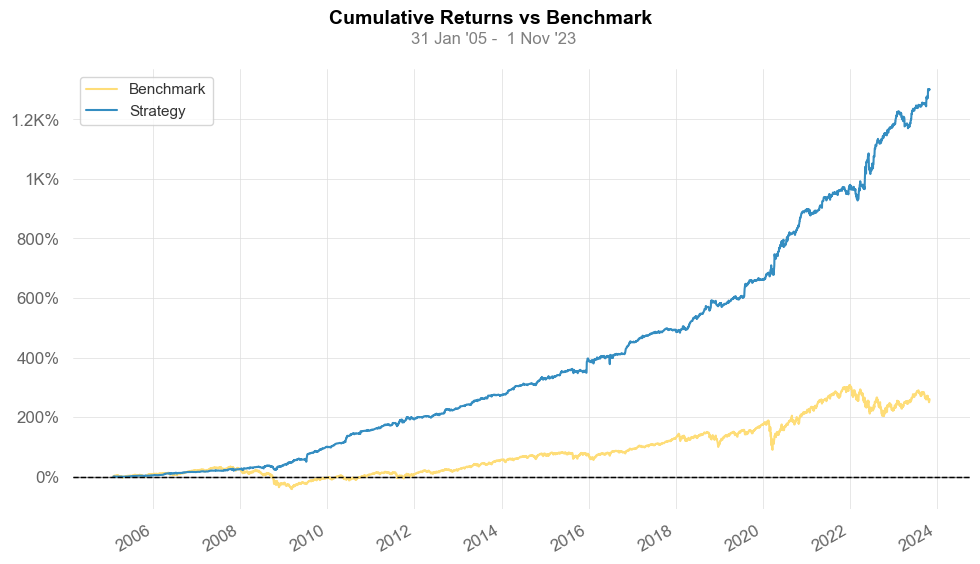

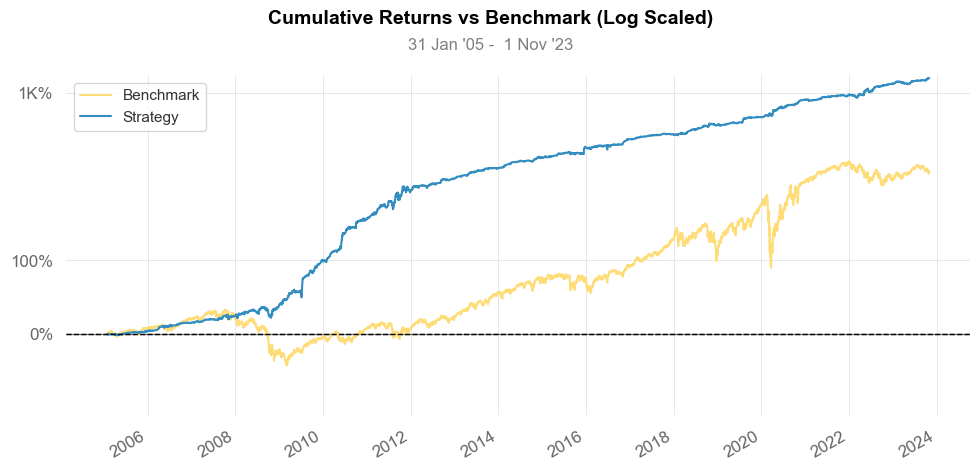

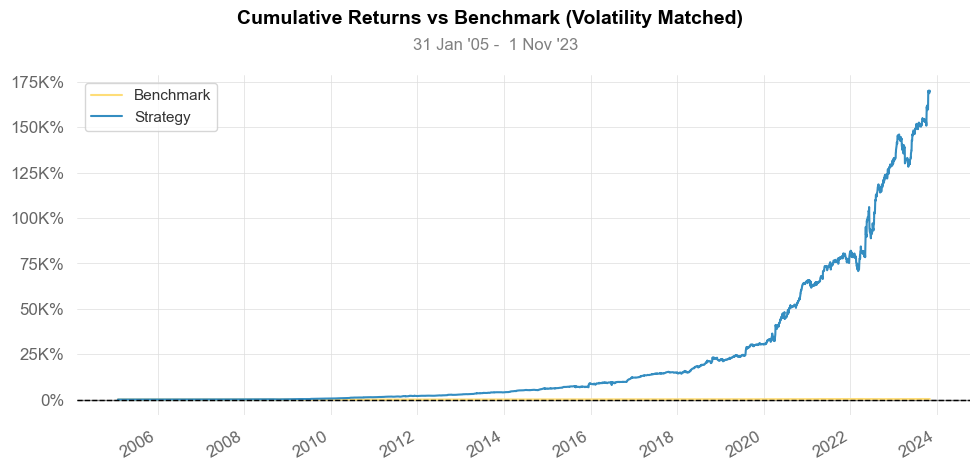

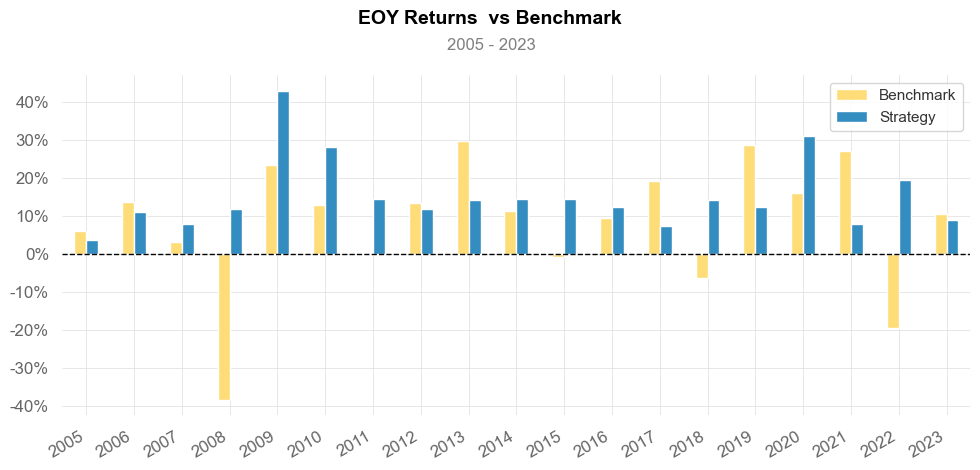

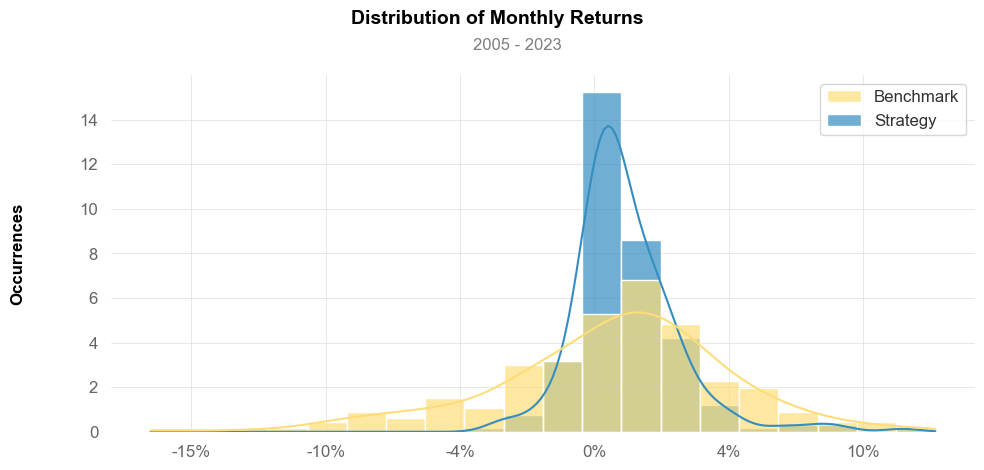

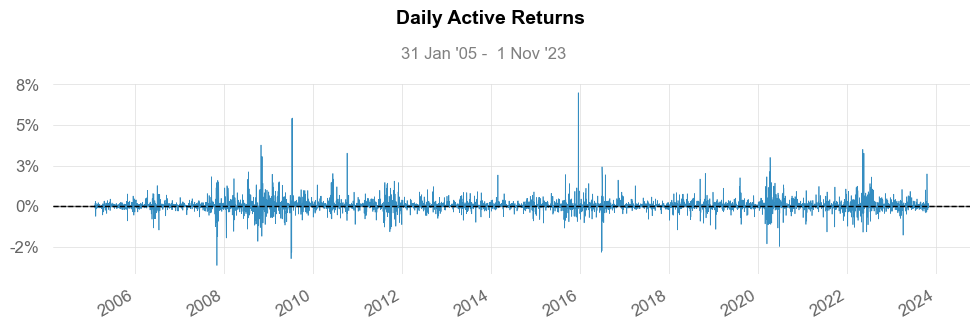

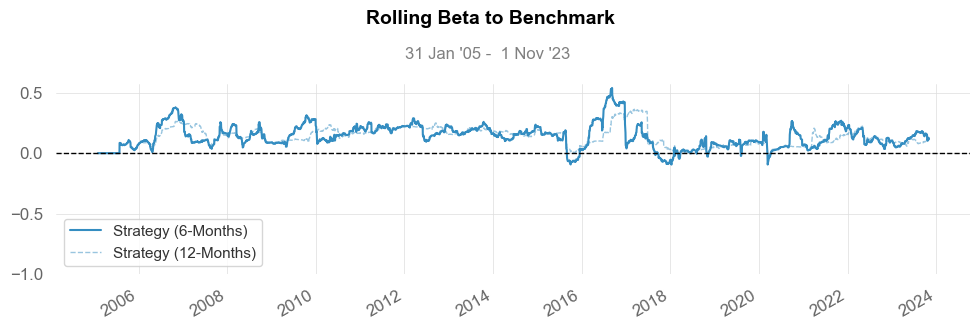

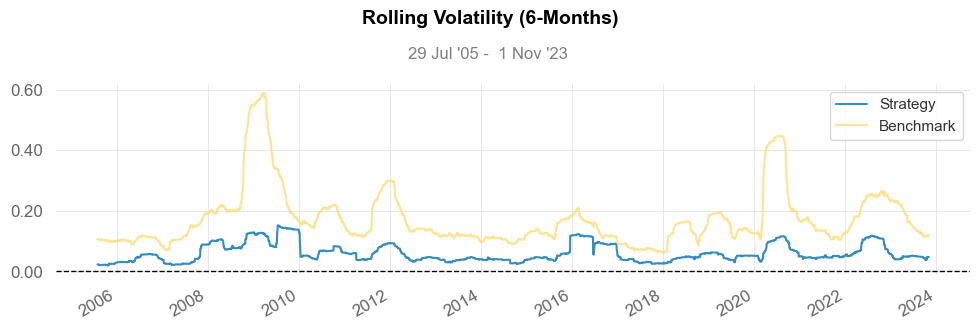

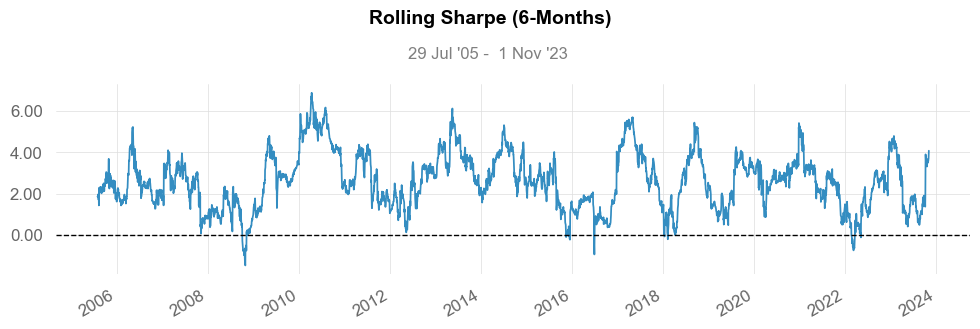

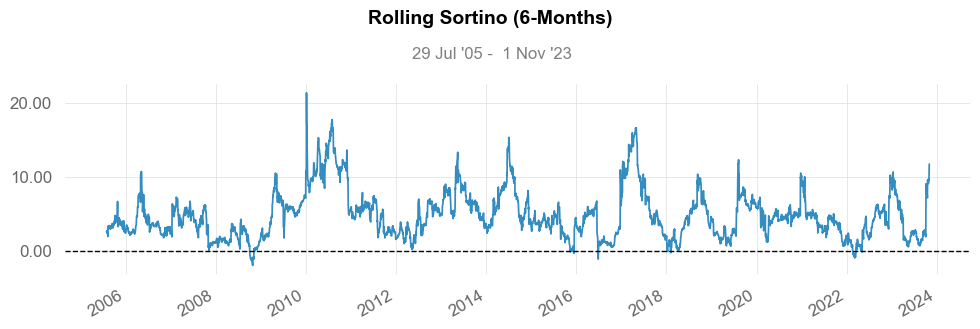

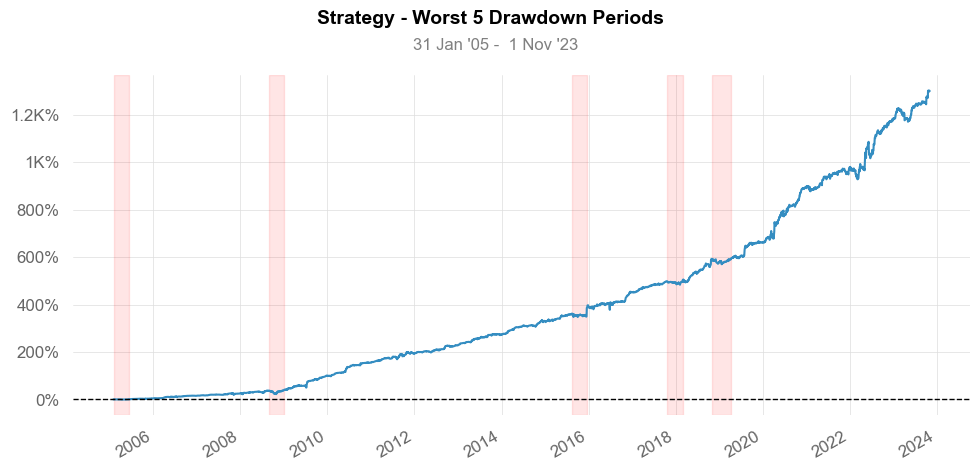

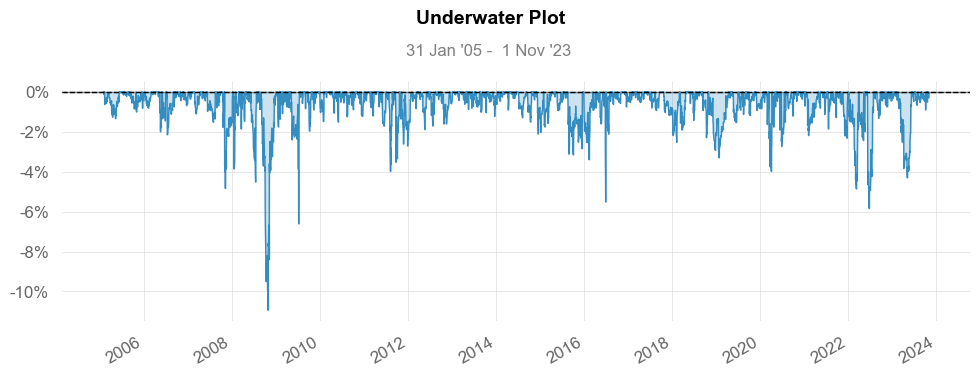

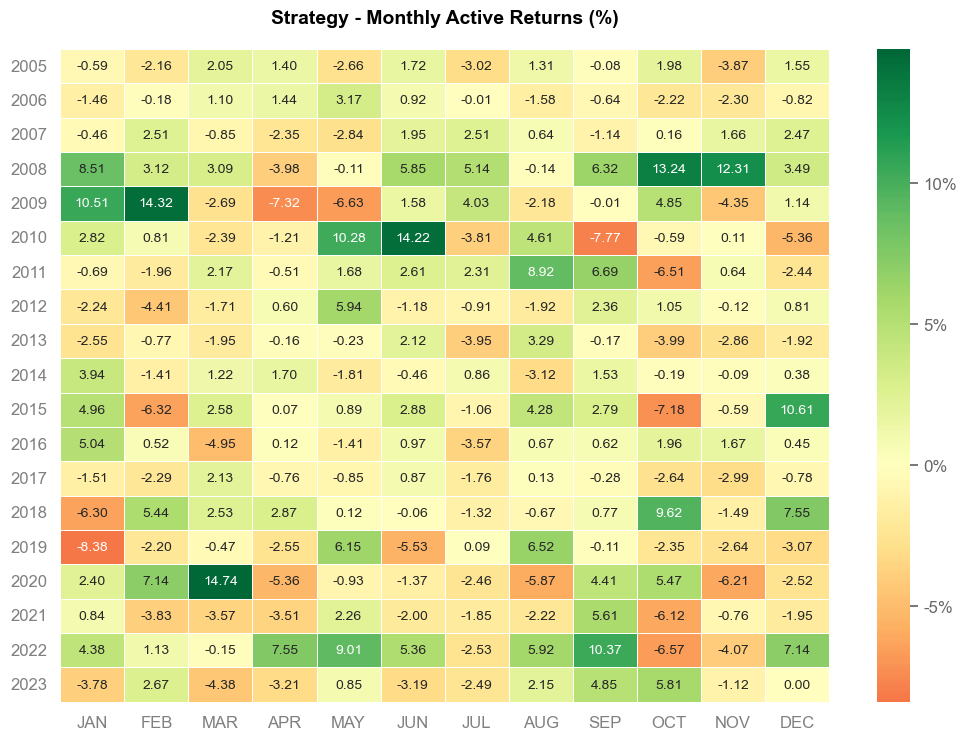

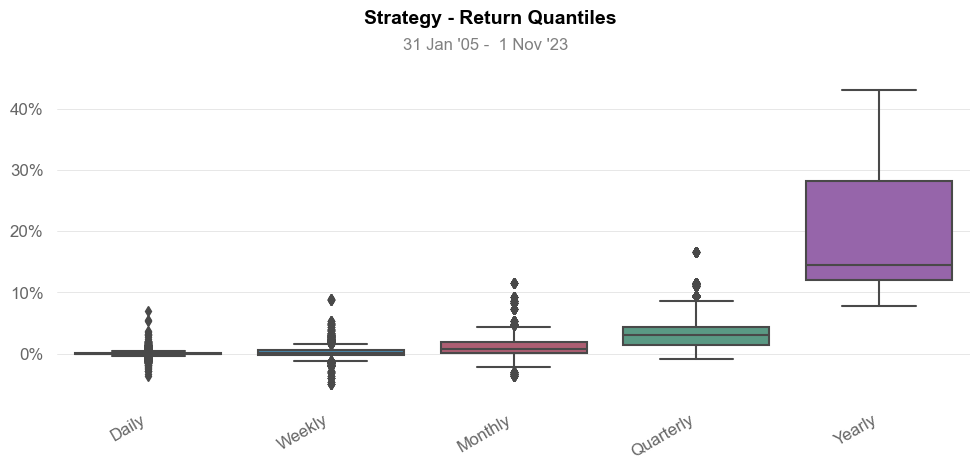

In [116]:
qs.reports.full(ewp_ret, "SPY", figsize=(10, 5))